In [1]:
import bayes3d as b
import jax.numpy as jnp
import numpy as np
import jax
import os
import matplotlib.pyplot as plt
import matplotlib
import trimesh
from tqdm import tqdm
from collections import namedtuple
import cv2

In [2]:
positions = np.loadtxt('ku_scene_vids_linear/cam_pos_ori0.txt')
positions.shape

with open("ku_scene_vids_linear/frames0/dense/sparse/images.txt", 'r') as file:
    data_array = []
    for line in file:
        # Split each line into a list of floats using spaces as the delimiter
        if line[0] == "#":
            continue
        float_list = [float(item) for item in line.strip().split()[:-1]]
        data_array.append(float_list)
        
posevecs = jnp.array(data_array[::2])[:,1:-1]

pose1 = posevecs[:,4:] # these two arrays have opposite conventions (quat, translation)
pose2 = positions[:,:3] #translation, quat

sf = np.linalg.norm(pose2[1]-pose2[0])/np.linalg.norm(pose1[1]-pose1[0])


In [3]:
bop_ycb_dir = os.path.join(b.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = b.utils.ycb_loader.get_test_img('54', '1', bop_ycb_dir)

intrinsics = b.Intrinsics(
    height=rgbd.intrinsics.height, width=rgbd.intrinsics.width,
    fx=rgbd.intrinsics.fx, fy=rgbd.intrinsics.fx,
    cx=rgbd.intrinsics.width/2, cy=rgbd.intrinsics.height/2,
    near=rgbd.intrinsics.near, far=rgbd.intrinsics.far
)

intrinsics = b.Intrinsics(
    height=rgbd.intrinsics.height, width=rgbd.intrinsics.width,
    fx=rgbd.intrinsics.fx, fy=rgbd.intrinsics.fx,
    cx=rgbd.intrinsics.width/2, cy=rgbd.intrinsics.height/2,
    near=rgbd.intrinsics.near, far=rgbd.intrinsics.far
)

# True scaling factor needs to be turned back on
scaling_factor = 1 #sf
# scaling_factor= 0.25
intrinsics = b.camera.scale_camera_parameters(intrinsics, scaling_factor)

In [4]:
renderer = b.Renderer(intrinsics)
#model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models_limited")
meshes = []
for idx in range(1,2):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    renderer.add_mesh_from_file(mesh_path,scaling_factor=1.0/1000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (640, 480, 1024)


In [17]:
poses = jnp.linalg.inv(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 1.0, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]))
    )

out = renderer.render(
        poses[None,...] , jnp.array([0])
    )

In [18]:
d_im = b.get_depth_image(out[:,:,2])

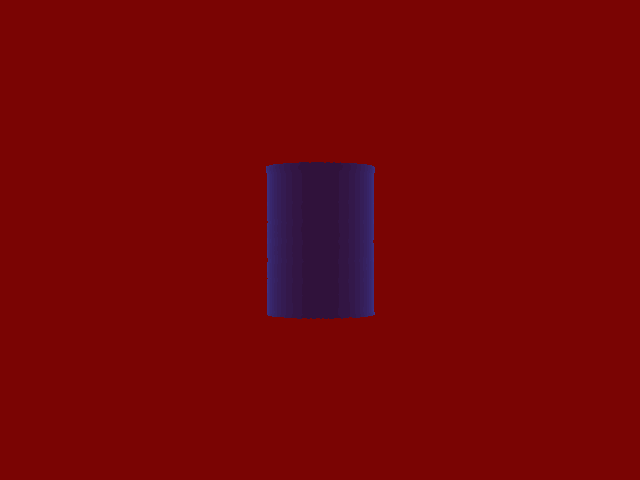

In [19]:
d_im

In [8]:
renderer.meshes[0]

<trimesh.Trimesh(vertices.shape=(9951, 3), faces.shape=(15728, 3))>

In [10]:
# pc_out = b.render_point_cloud(renderer.meshes[0].vertices,intrinsics)

In [11]:
#d_im = b.get_depth_image(pc_out[:,:,2])

In [12]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


In [14]:
b.show_trimesh('1',renderer.meshes[0])

In [16]:
b.show_pose('2', jnp.linalg.inv(poses))